In [1]:
#Install requirements
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Load Libraries
import numpy as np
import time
import datetime
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import Callback, TensorBoard, EarlyStopping

In [15]:
# Parameters
vocab_size = 10000
max_len = 500
embed_dim = 64
units = 64
batch_size = 128
epochs = 100

MODEL_RNN = "rnn_imdb.h5"
MODEL_LSTM = "lstm_imdb.h5"

# Load IMDB dataset
print("Loading IMDB dataset...")
(xtrain, ytrain), (xtest, ytest) = imdb.load_data(num_words=vocab_size)
print('Training samples:', len(xtrain))
print('Test samples:', len(xtest))

# Pad sequences
xtrain = pad_sequences(xtrain, maxlen=max_len)
xtest = pad_sequences(xtest, maxlen=max_len)

Loading IMDB dataset...
Training samples: 25000
Test samples: 25000


In [16]:
# Callback
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print("Epoch %d: loss=%.4f, acc=%.4f, val_loss=%.4f, val_acc=%.4f" %
              (epoch + 1,
               logs.get("loss", 0),
               logs.get("accuracy", 0),
               logs.get("val_loss", 0),
               logs.get("val_accuracy", 0)))

In [17]:
# Decode IMDB reviews
word_index = imdb.get_word_index()
reverse_word_index = {value + 3: key for (key, value) in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "the"

def decode_review(sequence):
    return " ".join(reverse_word_index.get(i, "?") for i in sequence)

In [18]:
# SIMPLE RNN MODEL

print("SIMPLE RNN MODEL ")

model_rnn = Sequential()
model_rnn.add(Embedding(vocab_size, embed_dim, input_length=max_len))
model_rnn.add(SimpleRNN(units))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.build(input_shape=(None, max_len))
model_rnn.summary()

SIMPLE RNN MODEL 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 500, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 648,321 (2.47 MB)

 Trainable params: 648,321 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train RNN
log_rnn = "logs/rnn_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
rnn_tb = TensorBoard(log_dir=log_rnn, histogram_freq=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

start = time.time()
history_rnn = model_rnn.fit(
    xtrain, ytrain,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[rnn_tb, early_stop, Callback()],
    verbose=2
)
end = time.time()
print("\nSimple RNN training time: %.2f seconds" % (end - start))

Epoch 1/100
Epoch 1: loss=0.6598, acc=0.5886, val_loss=0.6468, val_acc=0.5970
157/157 - 28s - 179ms/step - accuracy: 0.5886 - loss: 0.6598 - val_accuracy: 0.5970 - val_loss: 0.6468
Epoch 2/100
Epoch 2: loss=0.5421, acc=0.7420, val_loss=0.5738, val_acc=0.6852
157/157 - 26s - 168ms/step - accuracy: 0.7420 - loss: 0.5421 - val_accuracy: 0.6852 - val_loss: 0.5738
Epoch 3/100
Epoch 3: loss=0.2386, acc=0.9144, val_loss=0.4850, val_acc=0.7840
157/157 - 27s - 172ms/step - accuracy: 0.9144 - loss: 0.2386 - val_accuracy: 0.7840 - val_loss: 0.4850
Epoch 4/100
Epoch 4: loss=0.0595, acc=0.9857, val_loss=0.6530, val_acc=0.7406
157/157 - 27s - 175ms/step - accuracy: 0.9857 - loss: 0.0595 - val_accuracy: 0.7406 - val_loss: 0.6530
Epoch 5/100
Epoch 5: loss=0.0154, acc=0.9978, val_loss=0.6333, val_acc=0.7728
157/157 - 29s - 183ms/step - accuracy: 0.9978 - loss: 0.0154 - val_accuracy: 0.7728 - val_loss: 0.6333
Epoch 6/100
Epoch 6: loss=0.0040, acc=0.9999, val_loss=0.6714, val_acc=0.7776
157/157 - 29s - 1

In [20]:
# Save RNN model
model_rnn.save(MODEL_RNN)
print("Saved Simple RNN as:", MODEL_RNN)

Saved Simple RNN as: rnn_imdb.h5


In [26]:
# LSTM MODEL

print("\n LSTM MODEL ")
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embed_dim, input_length=max_len))
model_lstm.add(LSTM(units))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.build(input_shape=(None, max_len))
model_lstm.summary()


 LSTM MODEL 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 500, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train LSTM
log_lstm = "logs/lstm_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
lstm_tb = TensorBoard(log_dir=log_lstm, histogram_freq=1)
start = time.time()

history_lstm = model_lstm.fit(
    xtrain, ytrain,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[lstm_tb, early_stop, Callback()],
    verbose=2
)
end = time.time()
print("\nLSTM training time: %.2f seconds" % (end - start))

Epoch 1/100
Epoch 1: loss=0.5572, acc=0.6968, val_loss=0.3469, val_acc=0.8548
157/157 - 112s - 712ms/step - accuracy: 0.6968 - loss: 0.5572 - val_accuracy: 0.8548 - val_loss: 0.3469
Epoch 2/100
Epoch 2: loss=0.2857, acc=0.8867, val_loss=0.3617, val_acc=0.8412
157/157 - 115s - 731ms/step - accuracy: 0.8867 - loss: 0.2857 - val_accuracy: 0.8412 - val_loss: 0.3617
Epoch 3/100
Epoch 3: loss=0.2472, acc=0.9034, val_loss=0.3494, val_acc=0.8462
157/157 - 111s - 707ms/step - accuracy: 0.9034 - loss: 0.2472 - val_accuracy: 0.8462 - val_loss: 0.3494
Epoch 4/100
Epoch 4: loss=0.1735, acc=0.9368, val_loss=0.3099, val_acc=0.8734
157/157 - 112s - 716ms/step - accuracy: 0.9368 - loss: 0.1735 - val_accuracy: 0.8734 - val_loss: 0.3099
Epoch 5/100
Epoch 5: loss=0.1357, acc=0.9538, val_loss=0.4269, val_acc=0.8650
157/157 - 116s - 737ms/step - accuracy: 0.9538 - loss: 0.1357 - val_accuracy: 0.8650 - val_loss: 0.4269
Epoch 6/100
Epoch 6: loss=0.1162, acc=0.9586, val_loss=0.3945, val_acc=0.8772
157/157 - 12

In [28]:
# Save LSTM model
model_lstm.save(MODEL_LSTM)
print("Saved LSTM as:", MODEL_LSTM)

Saved LSTM as: lstm_imdb.h5


In [31]:
rnn_preds = (model_rnn.predict(xtest) > 0.5).astype(int)
lstm_preds = (model_lstm.predict(xtest) > 0.5).astype(int)
# Accuracy
print("RNN Accuracy:", accuracy_score(ytest, rnn_preds))
print("LSTM Accuracy:", accuracy_score(ytest, lstm_preds))

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step
RNN Accuracy: 0.77752
LSTM Accuracy: 0.86504


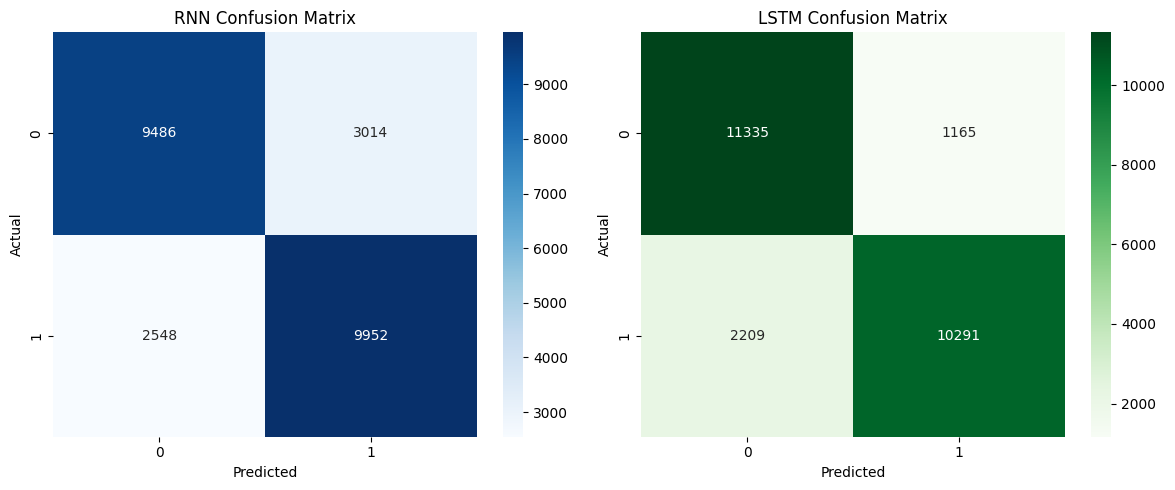

In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

cm_rnn = confusion_matrix(ytest, rnn_preds)
cm_lstm = confusion_matrix(ytest, lstm_preds)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RNN Confusion Matrix
sn.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("RNN Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# LSTM Confusion Matrix
sn.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("LSTM Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [33]:
# Evaluate LSTM
print('\nEvaluation on Test Set-LSTM')
test_loss, test_accuracy =model_lstm.evaluate(xtest, ytest, verbose=0)
print('Test Loss: %.4f' % test_loss)
print('Test Accuracy: %.4f' % test_accuracy)


Evaluation on Test Set-LSTM
Test Loss: 0.3293
Test Accuracy: 0.8650


In [38]:
# Decode function 
word_index = imdb.get_word_index()
reverse_word_index = {value+3: key for (key, value) in word_index.items()}
reverse_word_index[0] = '<PAD>'
reverse_word_index[1] = '<START>'
reverse_word_index[2] = '<UNK>'
reverse_word_index[3] = 'the'

def decode_review(seq):
    return ' '.join([reverse_word_index.get(i, '?') for i in seq if i != 0])

In [40]:
# Predictions
print('\n5 Sample test reviews ')
for i in range(5):
    seq = xtest[i]
    text = decode_review(seq)
    prob = model_lstm.predict(np.array([seq]), verbose=0)[0,0]  
    pred = 'Positive' if prob >= 0.5 else 'Negative'
    actual = 'Positive' if ytest[i] == 1 else 'Negative'
    print('\n--- Sample %d ---' % (i+1))
    print('Actual:', actual)
    print('Predicted: %s (prob=%.4f)' % (pred, prob))
    print('Review (truncated):', text[:600], '...\n')


5 Sample test reviews 

--- Sample 1 ---
Actual: Negative
Predicted: Negative (prob=0.1096)
Review (truncated): <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite <UNK> so all you madison fans give this a miss ...


--- Sample 2 ---
Actual: Positive
Predicted: Positive (prob=0.9887)
Review (truncated): <START> this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances <UNK> the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere <UNK> with sexual tension and psychological <UNK> it's very interesting that robert altman directed this considering the style and st

In [42]:
%load_ext tensorboard
%tensorboard --logdir logs/ --port 6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
